# Обобщение с помощью сверток
***

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn
import datetime
import torch.optim as optim

import collections

In [2]:
from torchvision import datasets
data_path = './data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

В предыдущей главе мы создали простую нейронную сеть, обучающуюся (или
переобучающуюся) на данных благодаря большому числу доступных для оптимизации параметров в линейных слоях. Впрочем, у нас были проблемы с нашей моделью, поскольку она запоминала обучающий набор данных лучше, чем обобщала
характеристики птиц и самолетов. Благодаря анализу архитектуры модели у нас
появилось предположение, почему так могло происходить. Из-за полносвязной
архитектуры, необходимой для обнаружения различных возможных сдвигов
птиц или самолетов на изображении, мы имеем слишком много параметров
(что облегчает запоминание моделью обучающего набора) и зависимость от
положения (что усложнет обобщение). Как мы обсуждали в предыдущей главе,
обучающие данные можно дополнить большим спектром перекадрированных
изображений, чтобы попытаться добиться обобщения на новых данных, но это
не решит проблему слишком большого количества параметров.


Существует способ получше! Он заключается в замене плотного, полносвязного
аффинного преобразования в нейроне нашей сети другой линейной операцией:
сверткой.

## Аргументы в пользу сверток

Давайте докопаемся до самой сути того, что такое свертки и как их использовать
в нейронных сетях. Да-да, сейчас мы на полпути к поиску решения задачи распознавания птиц и самолетов, но это отступление стоит того, чтобы потратить
на него время. Мы научимся интуитивно понимать эту основополагающую
концепцию машинного зрения, после чего с новыми суперспособностями вернемся к нашей задаче.

В этом разделе мы увидим, как свертки обеспечивают локальность и инвариантность относительно сдвига. Для этого мы внимательно изучим формулу,
описывающую свертки, и применим ее на бумаге, но не волнуйтесь, главное
будет на рисунках, а не в формулах.

Мы уже упоминали, что умножение одномерного представления нашего входного
изображения на матрицу весов **n_выходных_признаков × n_входных_признаков**, производимое в **nn.Linear**, означает вычисление для каждого канала изображения
взвешенной суммы всех пикселей, умноженной на множество весов, по одному
на выходной признак. Мы также говорили, что если нужно распознавать соответствующие объектам, например самолетам в небе, закономерности, вероятно,
понадобится проанализировать взаимное расположение близлежащих пикселей,
а сочетания более удаленных пикселей нас будет интересовать меньше. Фактически неважно, есть ли в углу нашего изображения «Спитфайра» дерево, облако
или воздушный змей.

Чтобы математически выразить наши интуитивные знания, можно вычислить
взвешенную сумму пикселя только с его непосредственными соседями, а не со
всеми прочими пикселями изображения. Это эквивалентно созданию весовых
матриц, по одной для каждого выходного признака и местоположения выходного
пикселя, в которых все веса на определенномрасстоянии от центрального пикселя
равны нулю. Такая сумма все равно будет взвешенной, то есть линейной операцией.

## Что делают свертки?

Мы уже указали ранее на одно желательное свойство: эти локализованные
закономерности должны влиять на выходной сигнал вне зависимости от их
местоположения на изображении, то есть обеспечивать инвариантность относительно сдвига. Чтобы добиться этого в использовавшейся в главе 7 матрице,
применяемой к изображению в виде вектора, понадобилось бы реализовать
довольно сложную закономерность весов (не волнуйтесь, если она покажется вам слишком сложной; скоро мы все усовершенствуем): большая часть весовой
матрицы должна была бы содержать нули (для записей, соответствующих входным пикселям, расположенным слишком далеко от выходного, чтобы на него
как-то повлиять). Для остальных весовых коэффициентов пришлось бы как-то
согласовывать записи, соответствующие одной относительной позиции входного
и выходного пикселей. Это значит, что необходимо задать для них одинаковые
начальные значения и гарантировать, что все эти связанные весовые коэффициенты остаются одинаковыми при обновлении сети во время обучения. Таким
образом мы гарантируем, что весовые коэффициенты реагируют на локальные
закономерности в неких окрестностях, причем эти локальные закономерности
распознаются независимо от того, где они встречаются на изображении.

Конечно, такой подход совершенно непригоден для использования на практике. 
К счастью, существует вполне доступная, локальная, инвариантная относительно
сдвига линейная операция над изображениями: свертка (convolution). Можно
описать свертку и более лаконично, но то, что далее описано, хотя и с несколько
нестандартной точки зрения, обладает всеми упомянутыми свойствами.

Свертка или, точнее, дискретная свертка (discrete convolution)1
, потому что существует и аналогичный непрерывный вариант свертки, который мы тут не будем
обсуждать, определяется для двумерногоизображения как скалярное произведение
матрицы весовых коэффициентов — ядра (kernel) — на каждую окрестность входных данных. Рассмотрим ядро 3 × 3 (в глубоком обучении обычно применяются
маленькие ядра; далее мы увидим почему), то есть двумерный тензор:

и одноканальное изображение MxN:

Элемент выходного изображения (без смещения) можно вычислить следующим
образом:

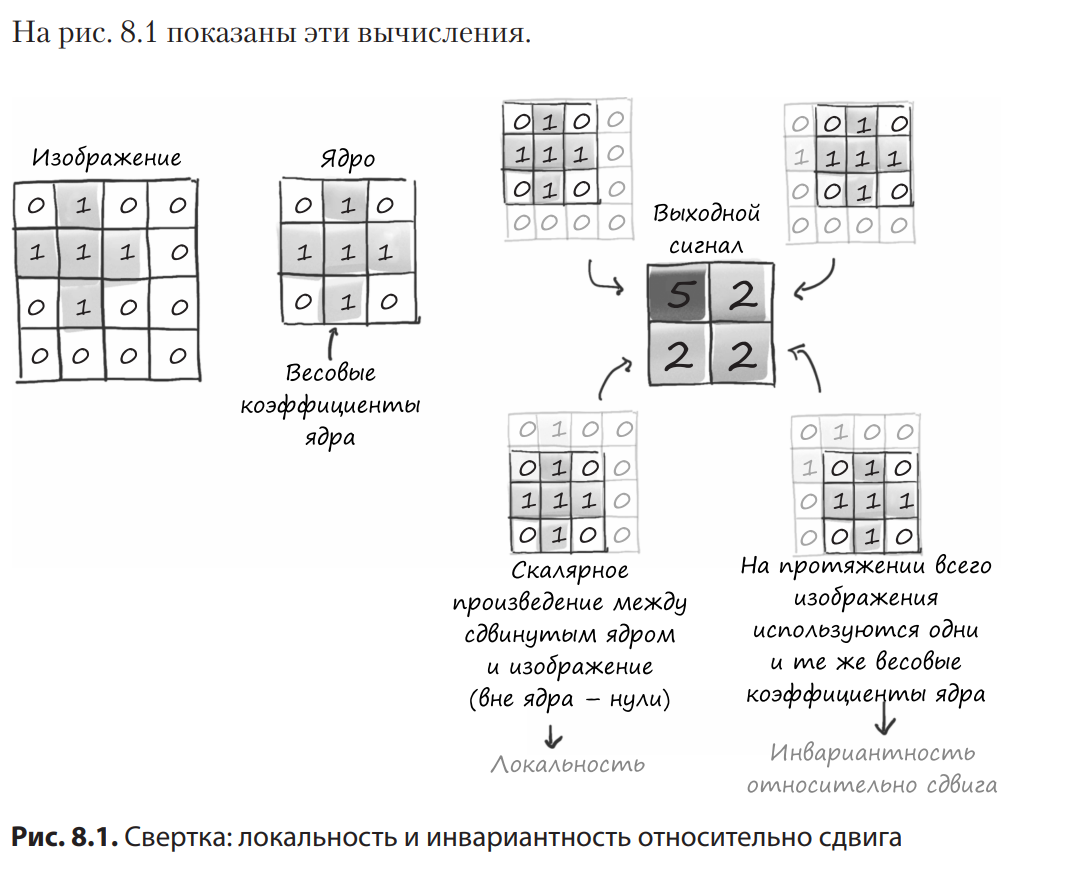

Другими словами, мы «сдвигаем» ядро на позицию i11 входного изображения
и умножаем каждый из весовых коэффициентов на значение из соответствующего
места входного изображения. Таким образом, выходное изображение получается
путем сдвига ядра по всем позициям входного изображения и вычисления взвешенной суммы. В случае многоканального изображения, например для нашего
RGB-изображения, матрица весов будет иметь форму 3 × 3 × 3: для каждого
канала по одному набору весов, вносящему свой вклад в выходные значения.

Учтите, что, подобно элементам матрицы weight объекта nn.Linear, весовые
коэффициенты ядра заранее не известны, а инициализируются случайным
образом и обновляются посредством обратного распространения ошибки. Отметим также, что для всего изображения используется одно и то же ядро, а это
значит, что и весовые коэффициенты ядра. Если вернуться к автоматическому
вычислению градиентов, это значит, что у каждого весового коэффициента есть
история, охватывающая все изображение. Следовательно, в производную функции потерь по сверточным весам вносит свой вклад все изображение

Теперь нам ясна связь с тем, о чем мы говорили ранее: свертка эквивалентна
нескольким линейным операциям, весовые коэффициенты которых равны
нулю практически везде, кроме окрестностей отдельных пикселей, и получают
одинаковые обновления во время обучения

В итоге благодаря переходу на свертки мы получаем:

* локальные операции над окрестностями отдельных пикселей;
* инвариантность относительно сдвига;
* уменьшение числа параметров моделей.

Главное в третьем пункте то, что при использовании сверточного слоя количество параметров зависит не от числа пикселей в изображении, как в случае
полносвязной модели, а от размера ядра свертки (3 × 3, 5 × 5 и т. д.), а также от
числа сверточных фильтров (или выходных каналов) модели.

## Свертки в действии

Похоже,мы потратили уже достаточно времени на теорию! Давайте посмотримна
PyTorch в действии на нашей задаче с птичками и самолетами. Модуль torch.nn
позволяет производить свертки в одном, двух и трех измерениях: nn.Conv1d для
временных рядов, nn.Conv2d для изображений и nn.Conv3d для объемных пространственных данных или видеоданных

Для нашего набора данных CIFAR-10 подойдет nn.Conv2d. В качестве аргументов для nn.Conv2d необходимо указать как минимум число входных признаков
(или каналов, поскольку наши изображения — многоканальные, то есть содержат более одного значения на пиксель), число выходных признаков и размер
ядра. Например, у нас три входных признака на пиксель (канала RGB) для
первого сверточного модуля и произвольного количества выходных каналов —
допустим, 16. Чем больше каналов в выходном изображении, тем больше разрешающие возможности сети. Каналы нужны, чтобы обнаруживать различные
типы признаков. Кроме того, поскольку начальные значения для них задаются
случайным образом, часть полученных признаков даже после обучения окажутся
бесполезными1
. Давайте остановимся на ядре размером 3 × 3.

Очень часто применяют ядра, размеры которых одинаковы по всем измерениям,
поэтому в PyTorch есть сокращенная форма записи для них: kernel_size=3 для
двумерной свертки означает форму 3 × 3 (вPython задается в виде кортежа (3, 3)),
для трехмерной свертки — форму 3 × 3 × 3. У КТ-снимков, которые мы увидим
в части II этой книги, разрешение вокселей (объемных пространственных пикселей) по одной из трех осей координат отличается. В противном случае имеет
смысл использовать ядра с отдельнымразмеромдля этого конкретного измерения. 
Но пока чтомы остановимся на свертках одинакового размера по всемизмерениям:

In [4]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

Мы видим, что свертки прекрасно подходят для усвоения информации из
изображений. Модели становятся меньше и ищут локальные закономерности, весовые коэффициенты которых оптимизированы на основе всего
изображения

В результате прохода двумерной свертки получается двумерное изображение,
пиксели которого представляют собой взвешенную сумму значений по локальным окрестностям входного изображения.

В нашем случае как начальные значения весовых коэффициентов ядра conv.
weight, так и смещения задаются случайным образом, так что выходное изображение особого смысла не несет. Как обычно, необходимо с помощью unsqueeze
добавить нулевое измерение батчей для вызова модуля conv с одним входным
изображением, поскольку nn.Conv2d ожидает на входе тензор формы B × C × H × W:

In [6]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Интересно будет посмотреть на output, показанный на рис. 8.2:

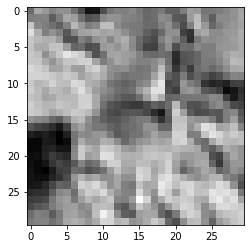

In [7]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

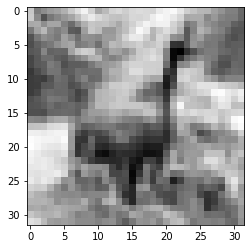

In [8]:
plt.imshow(img[0], cmap='gray')
plt.show()

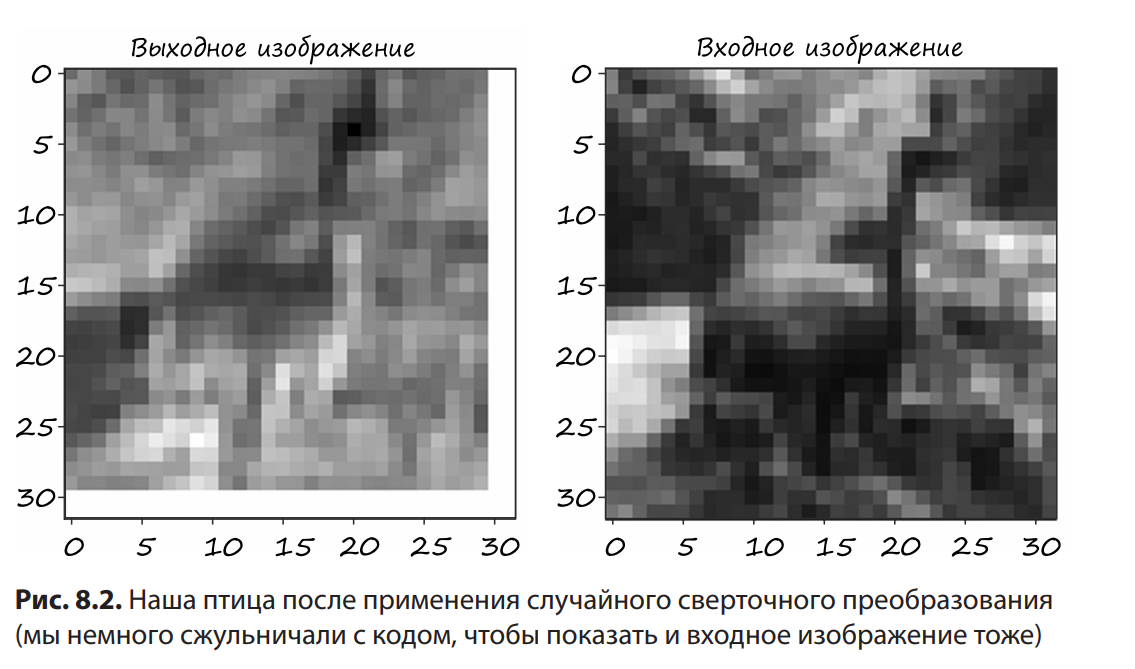

Погодите-ка. Взглянем на размер output: torch.Size([1, 16, 30, 30]). Кхм, похоже, мы потеряли несколько пикселей по пути. Как же это случилось

## Дополнение нулями по краям

То, что наше выходное изображение меньше входного, является побочным эффектом принятия решения о том, что делать на краях изображения. Применение
сверточного ядра в виде взвешенной суммы пикселей в окрестности размера
3 × 3 требует наличия соседних пикселей во всех направлениях. А в точке i00
соседние пиксели есть только справа и снизу. По умолчанию сверточное ядро
в PyTorch проходит по входному изображению, получая ширина - ширина_ядра + 1
по горизонтали и вертикали. В случае ядер нечетного размера в результате получаются изображения, которые меньше с каждой стороны на половину ширины
сверточного ядра (в нашем случае 3 // 2 = 1). Поэтому нам и не хватает по два
пикселя в каждом измерении.

Впрочем, PyTorch позволяет дополнять нулями (padding) изображения, путем
добавления границ с помощью фиктивных (ghost) пикселей с нулевымзначением. 
На рис. 8.3 показано, как происходит дополнение нулями.

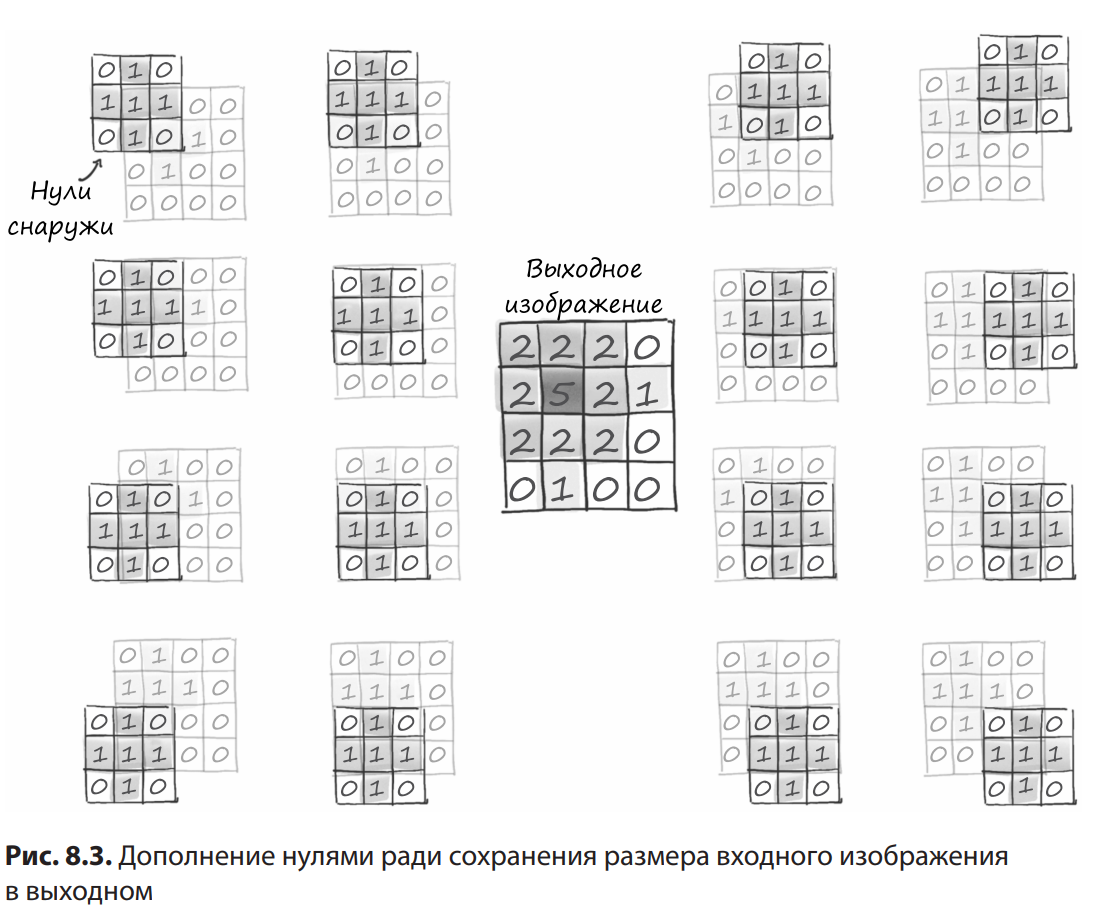

В нашем случае параметр padding=1 при kernel_size=3 означает появление
у i00 набора дополнительных соседей сверху и слева, что позволяет вычислять
выходной сигнал свертки даже в углу исходного изображения1
. В итоге размер
выходного изображения оказывается точно таким же, как и входного

Для ядер четного размера пришлось бы дополнять другим количеством соседей
слева и справа (а также сверху и снизу). PyTorch не предоставляет подобной возможности в самой свертке, но дает возможность решить эту задачу с помощью функции
torch.nn.functional.pad. Но лучше придерживаться нечетных размеров ядер; ядра четного
размера встречаются редко

In [9]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # Теперь дополнено нулями
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Обратите внимание, что размеры weight и bias не меняются вне зависимости
от дополнения.

Существует две основные причины для дополнения сверток. Во-первых, чтобы разделять задачи выполнения свертки и изменения размера изображения
и помнить на одну вещь меньше. Во-вторых, для более изощренных структур,
например обходных связей (skip connections)1 (обсуждаются в подразделе 8.5.3)
и сети U-Nets, которые мы рассмотрим в части II, желательно, чтобы размеры
тензоров до и после нескольких сверток оставались совместимыми, чтобы их
можно было складывать и вычитать

##  Обнаружение признаков с помощью сверток

Мы уже говорили, что weight и bias — это параметры, усваиваемые посредством
обратного распространения ошибки, точно так же, как weight и bias в nn.Linear. 
Однако можно поэкспериментировать со сверткой, задавая весовые коэффициенты вручную, и посмотреть, что получится.

Сначала обнулим bias, просто чтобы исключить все мешающие факторы, после
чего зададимконстантное значение weight, чтобы каждый пиксель выходного изображения получал среднее значение своих соседей. Для каждой окрестности 3 × 3:

In [10]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

Можно было воспользоваться conv.weight.one_() — при этом каждый пиксель
выходного изображения был бы равен сумме окрестных пикселей. Различия незначительны, разве что значения пикселей в выходном изображении оказались
бы в девять раз больше

В любомслучае взглянем, как это повлияет на наше изображение из набора CIFAR:

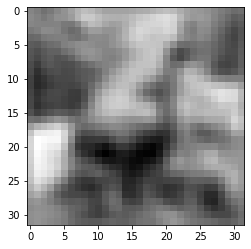

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Как можно было предвидеть, фильтр генерирует размытую версию изображения,
как показано на рис. 8.4. В конце концов, каждый пиксель выходного изображения представляет собой среднее значение одной из окрестностей входного
изображения, так что пиксели выходного изображения связаны друг с другом
и меняются более гладко

Попробуем что-нибудь другое. На первый взгляд следующее ядро может показаться довольно загадочным:

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

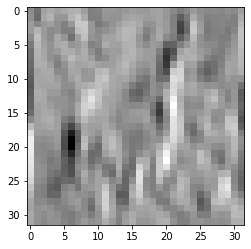

In [13]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

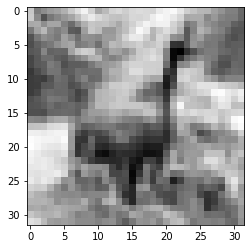

In [14]:
plt.imshow(img[0], cmap='gray')
plt.show()

Если записать выражение взвешенной суммы для произвольного пикселя на
позиции 2,2, как мы делали ранее для общего сверточного ядра, то мы получим

Здесь вычисляется разность всех пикселей справа от i22 и пикселей слева от
него. В случае применения ядра к вертикальной границе между двумя смежными
областями различной яркости значение o22 будет выше. При применении же
ядра к области равномерной яркости значение o22 будет нулевым. Таким образом, наше ядро выявляет края, подчеркивая вертикальные края между двумя
смежными по горизонтали областями

Применяя к нашему изображению сверточное ядро, получаем показанный на
рис. 8.5 результат. Как и ожидалось, сверточное ядро усиливает вертикальные
края. Можно создать намного более изощренные фильтры, например, для обнаружения горизонтальных и диагональных краев, крестовидных или расположенных


в шахматном порядке узоров, где «обнаружение» означает высокие порядки
значений в выходном изображении. На самом деле исторически задача специалиста по машинному зрению и заключалась в поиске наиболее эффективного
сочетания фильтров для выделения определенных признаков в изображениях
и распознавания объектов.

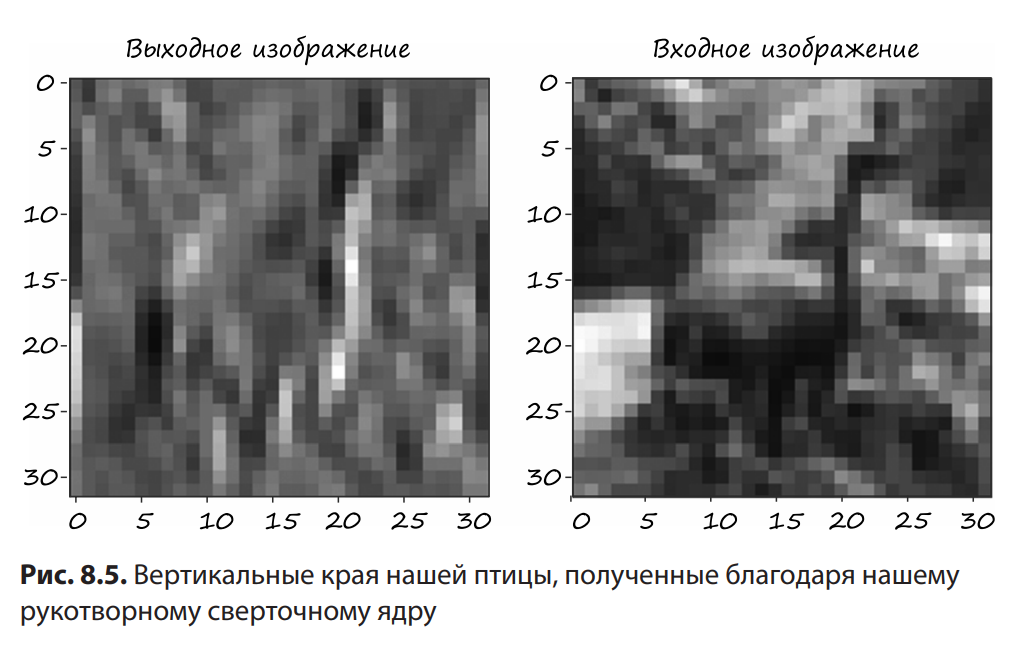

При использовании глубокого обучения оценка ядер может производиться
так, чтобы модель различала как можно эффективнее: например, в контексте
минимизации функции потерь на основе отрицательной перекрестной энтропии
между выходным сигналом и эталонными данными, с которой мы познакомили
вас в подразделе 7.2.5. С этой точки зрения задача сверточной нейронной сети
состоит в оценке ядра набора фильтров в последовательных слоях, преобразующих многоканальное изображение в другое многоканальное изображение,
в котором различные каналы соответствуют разным признакам (например,
один канал — для среднего значения, другой — для вертикальных краев и т. д.). 
На рис. 8.6 показано, как модель автоматически усваивает ядра.

## Расширяем кругозор с помощью субдискретизации и повышения глубины сети

Все это очень хорошо, но остается главный вопрос. Мы обрадовались, что
благодаря переходу от полносвязных слоев к сверткам добились локальности
и инвариантности относительно сдвига. Дальше мы рекомендовали использовать маленькие ядра (3 × 3 или 5 × 5), и локальность достигла максимума, это
прекрасно. Но как насчет общей картины? Откуда мы знаем, что все структуры

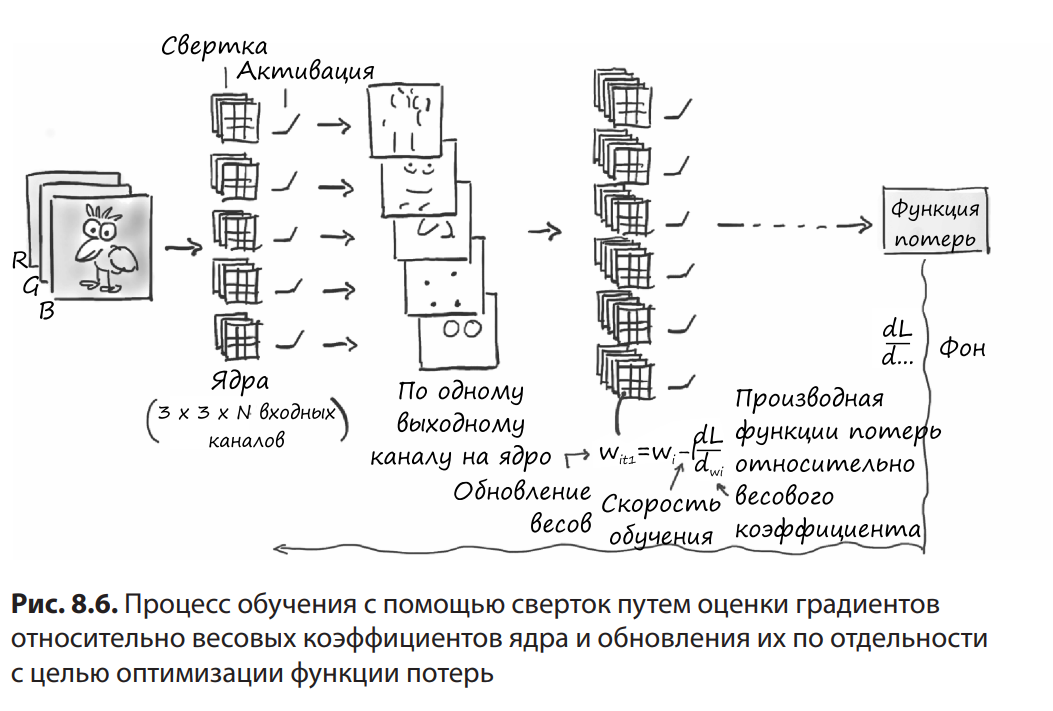

в наших изображениях — шириной 3 или 5 пикселей? Что ж, на самом деле не
знаем, поскольку это просто не так. А раз это не так, как же наши сети смогут
обнаружить закономерности большего масштаба? А это нам точно понадобится
для эффективного решения задачи различения птиц от самолетов, поскольку,
хотя изображения CIFAR-10 и невелики, размах (крыльев) объектов может достигать двузначного числа пикселей.

Одним из вариантов будет воспользоваться большими сверточными ядрами. 
Что ж, конечно, в крайнем случае можно использовать ядро 32 × 32 для изображения 32 × 32, но при этом мы вернемся к старому доброму полносвязному
аффинному преобразованиюи утратимвсе преимущества свертки. Другой вариант,
используемый в сверточных нейронных сетях, заключается в использовании нескольких сверток, одной за другой, с понижающей дискретизацией между ними.

### От большого к малому: понижающая дискретизация

Понижающая дискретизация может происходить по-разному. Уменьшение изображения вдвое эквивалентно генерации одного пикселя на выходе на основе
четырех соседних пикселей на входе. Как именно вычислять значение на выходе
по значениям на входе — наше дело. Можно:

* усреднять значения четырех входных пикселей — изначально весьма распространенный подход под названием «усредняющая субдискретизация» (average pooling), несколько утративший популярность в последнее время;

* брать максимум из значений четырех входных пикселей — в настоящее время чаще всего используется именно этот подход: субдискретизация с выбором максимального значения (max pooling). Его недостаток в том, что отбрасываются три четверти данных;

* шаговая свертка (strided convolution), при которой учитывается лишь каждый N-й пиксель — свертка 3 × 4 с шагом 2 позволяет учесть значения всех пикселей предыдущего слоя. Судя по публикациям, этот подход весьма перспективен, хотя и не вытеснил пока что субдискретизацию с выбором максимального значения.

Далее мы сосредоточим свое внимание на субдискретизации с выбором максимального значения, показанной на рис. 8.7. На рисунке приведена наиболее
распространенная схема, в которой в качестве значения нового пикселя уменьшенного изображения берется максимум по неперекрывающимся плиткам 2 × 2.

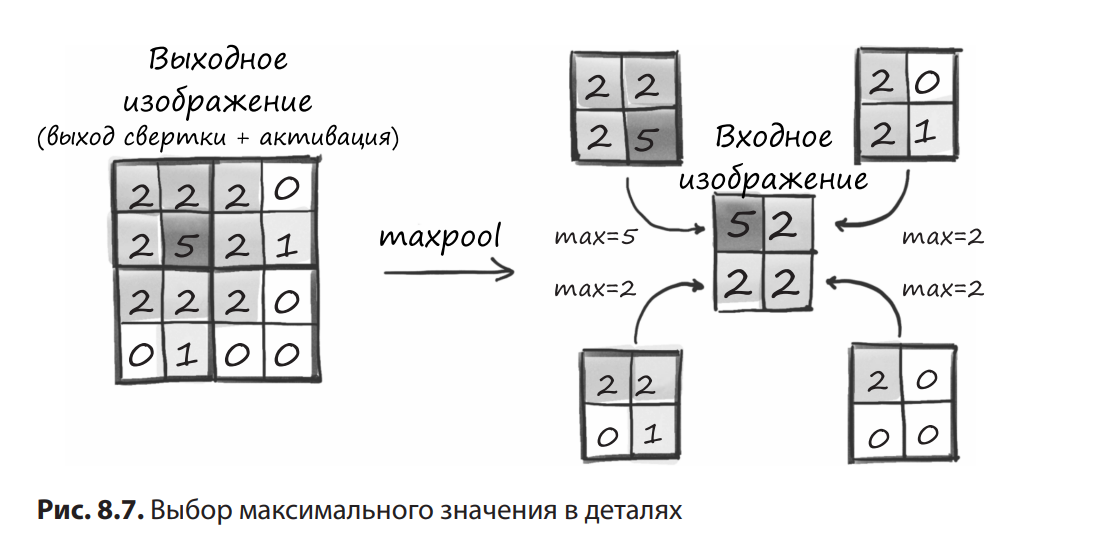

Интуитивно понятно, что порядок значений выходных изображений из сверточного слоя, особенно если за ним следует функция активации, как и за любым
другим линейным слоем, обычно оказывается довольно большим там, где обнаружены определенные признаки, соответствующие используемому ядру (например, вертикальные линии). Использование в качестве субдискретизированного
выходного значения максимума из значений в окрестности размером 2 × 2 гарантирует сохранение обнаруженных признаков в процессе субдискретизации,
за счет более слабых сигналов.

Возможности субдискретизации с выбором максимального значения предоставляет модуль nn.MaxPool2d (как и для свертки, существуют его версии для одномерных и трехмерных данных). В качестве входного аргумента ему передается
размер окрестности для работы операции субдискретизации. Например, для
понижающей дискретизации изображения в два раза необходимо передавать
значение 2. Давайте проверим, что все работает правильно, прямо на нашем
входном изображении:

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

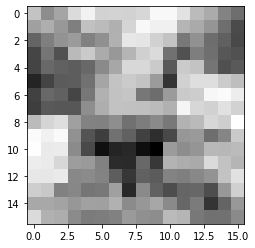

In [16]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

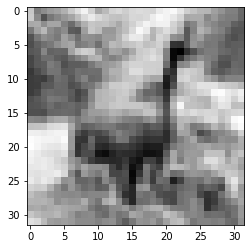

In [17]:
plt.imshow(img[0], cmap='gray')
plt.show()

### Сочетание сверточных слоев и понижающей дискретизации для лучшего распознавания

Посмотрим теперь, как сочетание сверточных слоев и понижающей дискретизации позволяет распознавать более крупные структуры. На рис. 8.8 мы начинаем
с применения набора ядер 3 × 3 к изображению размера 8 × 8, в результате чего
получается многоканальное изображение того же размера. Затем мы масштабируем изображение наполовину, получая изображение 4 × 4, и применяем к нему
еще один набор ядер 3 × 3. Этот второй набор ядер работает с окрестностями 3 × 3
изображения, которое было уменьшено вдвое, фактически соответствующими
окрестностям 8 × 8 исходного изображения. Кроме того, второй набор ядер
получает на входе выходной сигнал первого набора ядер (признаки наподобие
средних значений, краев и т. д.) и выделяет еще дополнительные признаки.

Итак, первый набор ядер работает с маленькими окрестностями низкоуровневых
признаков первого порядка, а второй набор фактически работает с более широкими окрестностями, генерируя признаки, представляющие собой композицию
предыдущих признаков. Благодаря этому замечательному механизму сверточные
нейронные сети способны анализировать очень сложные кадры — намного сложнее
наших изображений 32 × 32 из набора данных CIFAR-10.

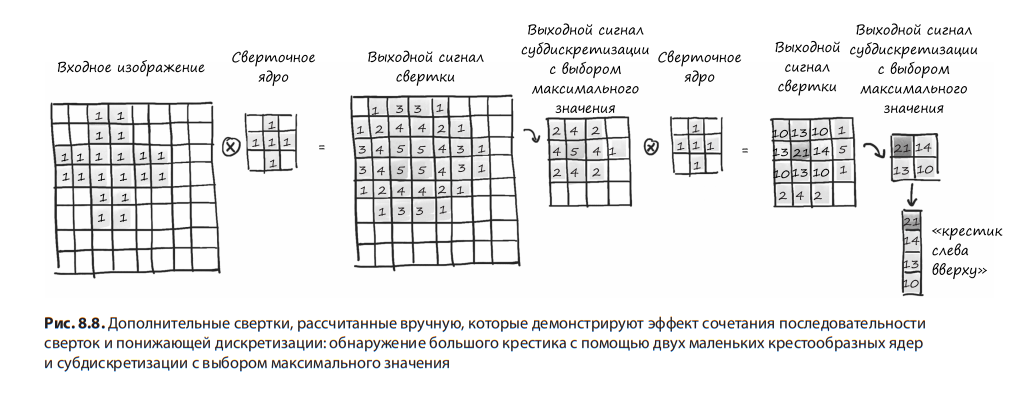

### Собираем нашу нейронную сеть воедино

Теперь у нас есть все «кирпичики», чтобы создать нашу сверточную нейронную
сеть для различения птиц и самолетов. Возьмем в качестве отправной точки
нашу предыдущую полносвязную модель и введем в нее вышеупомянутые слои
nn.Conv2d и nn.MaxPool2d:

In [18]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

Первая операция свертки превращает три канала RGB в 16, благодаря чему у сети
появляется возможность генерировать 16 независимых признаков, которые (надеемся) позволят различить низкоуровневые признаки птиц и самолетов. Далее
мы применяем функцию активации Tanh. Полученное 16-канальное изображение
32 × 32 субдискретизируется первым слоем nn.MaxPool2d до 16-канального изображения 16 × 16. Теперь субдискретизированное изображение подвергается еще
одной операции свертки, выдающей на выходе 8-канальный выходной сигнал
16 × 16. Если повезет, это выходное изображение будет состоять из высокоуровневых признаков. И опять же мы применяем функцию активации Tanh, после чего
производим субдискретизацию до 8-канального выходного изображения 8 × 8.

Когда же этот процесс завершается? После уменьшения входного изображения
до набора 8 × 8 признаков можно надеяться вернуть из сети значения вероятностей, подходящих для подачи на вход отрицательной логарифмической
функции правдоподобия. Однако вероятности представляют собой пару чисел
в одномерном векторе (одно для самолета, одно для птицы), а мы все еще имеем
дело с многоканальными двумерными признаками.

Вспоминая начало этой главы, мы уже знаем, что нужно сделать: преобразовать
8-канальное изображение 8 × 8 в одномерный вектор и завершить нашу сеть
набором полносвязных слоев:

В результате этого кода получается изображенная на рис. 8.9 нейронная сеть

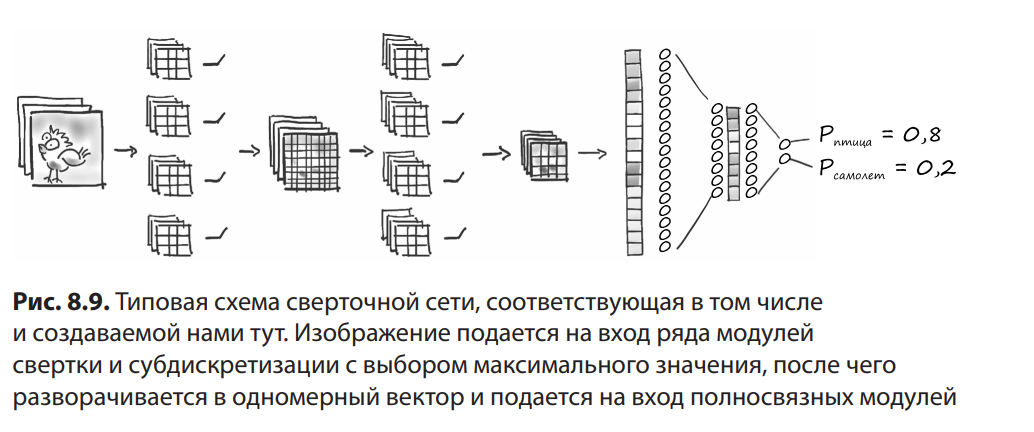

Забудем на минуту про комментарий «что-то пропущено». Обратим сначала
внимание на то, что размер линейного слоя зависит от ожидаемого размера
выходного сигнала слоя MaxPool2d: 8 × 8 × 8 = 512. Посчитаем количество параметров этой небольшой модели:


In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Вполне приемлемо для ограниченного набора таких маленьких изображений. 
Для повышения разрешающих возможностей модели можно увеличить количество выходных каналов сверточных слоев (то есть число признаков, генерируемых каждым из сверточных слоев), в результате чего увеличится и размер
линейного слоя

Впрочем, примечание «Внимание» в коде было совсем не случайным. Модель
обязательно пожалуется при запуске

In [20]:
model(img.unsqueeze(0))

tensor([[0.2246, 0.1638]], grad_fn=<AddmmBackward0>)

Следует признать, это сообщение об ошибке выглядит довольно туманно, но
не слишком. В трассировке можно заметить упоминания linear, а если взглянуть снова на модель, можно заметить, что единственный модуль с тензором
512 × 32 — это nn.Linear(512, 32), первый линейный модуль, следующий за
последним сверточным блоком

Здесь недостает шага изменения формы, с 8-канального изображения 8 × 8 на
состоящий из 512 элементов одномерный вектор (одномерный, если не считать
измерения батчей). Это можно сделать, вызвав метод view для выходного сигнала
nn.MaxPool2d, но, к сожалению, у нас нет явного доступа к выходным сигналам
модулей при использовании nn.Sequential

### Создание подклассов nn.Module

На определенном этапе разработки нейронных сетей возникает необходимость
вычислить что-то, не охваченное уже готовыми модулями. В нашем случае это
такая простая вещь, как изменение формы2
; но в подразделе 8.5.3 мы воспользуемся той же конструкцией для реализации остаточных связей. Так что в этом
разделе мы научимся создавать свои собственные подклассы nn.Module, которые
можно использовать точно так же, как уже готовые или как nn.Sequential.

Для создания моделей, способных на вещи более сложные, чем просто применение одного слоя за другим, необходимо использовать вместо nn.Sequential
нечто с большей гибкостью. PyTorch позволяет производить в модели любые
вычисления путем создания подклассов nn.Module.

Для создания подкласса nn.Module как минимум необходимо описать функцию forward, принимающую входные сигналы модуля и возвращающую выходной. Именно в ней и описываются производимые модулем вычисления. 
Название forward — это наследие давнего прошлого, когда в модуле должны
были быть описаны как прямой, так и обратный проходы, встречавшиеся нам
в подразделе 5.5.1. При использовании PyTorch и стандартных операций torch
модуль autograd автоматически производит обратный проход; и действительно,
nn.Module никогда не содержит backward

Обычно в вычислениях используются и другие модули — готовые, например,
свертки или пользовательские. Эти подмодули (submodules) обычно включаются
в программу посредством описания в конструкторе __init__ и присваивания их self для использования в функции forward. Их параметры в то же время
хранятся в них на протяжении всего жизненного цикла нашего модуля. Обратите внимание, что перед этим необходимо вызвать super().__init__() (иначе
PyTorch напомнит вам об этом)

## Наша сеть как подкласс nn.Module

Напишем нашу сеть в виде подмодуля. Для этого создадим все экземпляры
всех слоев nn.Conv2d, nn.Linear и т. д., которые выше передавали в конструктор,
а затем воспользуемся этими экземплярами один за другим в функции forward:

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.veiw(-1, 8*8*8) # Можно заменить на nn.Flatten()
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

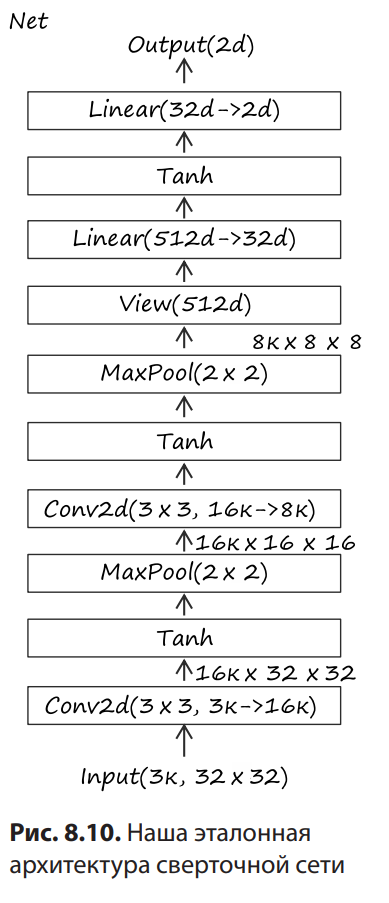

## Как PyTorch отслеживает параметры и подмодули

Любопытно, что присвоение экземпляра nn.Module атрибуту nn.Module, как
было сделано в приведенном выше конструкторе, приводит к автоматической
регистрации этого модуля в качестве подмодуля.

Можно вызывать любые методы подкласса nn.Module. Например, в модели,
где процесс обучения существенно отличается от, скажем, предсказания, не
помешает метод predict. Учтите, что вызовы подобных методов аналогичны
вызову forward вместо самого модуля: они ничего не знают о точках привязки,
и JIT при их использовании не видит структуры модуля, поскольку отсутствует
эквивалент элементов __call__, показанных в подразделе 6.2.1.

Благодаря этому для доступа из Net к параметрам подмодулей не требуется
каких-либо дополнительных действий пользователя:

In [22]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Здесь вызов model.parameters() заходит во все подмодули, присвоенные
атрибутам в конструкторе, и рекурсивно вызывает их методы parameters(). 
Вне зависимости от степени вложенности подмодуля, любой объект nn.Module
может получить доступ к списку всех дочерних параметров. А обращаясь к их
заполненному autograd атрибуту grad, оптимизатор знает, как модифицировать
параметры так, чтобы снизить потери. Все это известно нам из главы 5.

Теперь мы знаем, как создавать свои собственные модули, и эти знания нам очень
даже пригодятся в части II. Если вернуться к реализации класса Net и задуматься
о целесообразности регистрации подмодулей в конструкторе для обращения
к их параметрам, возникает впечатление, что регистрация подмодулей без параметров, например nn.Tanh и nn.MaxPool2d, — только лишняя трата ресурсов. 
Не проще ли было бы вызывать их непосредственно в функции forward точно
так же, как мы вызывали view?

***
## Функциональные API

Конечно, проще! Именно поэтому в PyTorch есть функциональные аналоги
для всех модулей nn. Под функциональными мы подразумеваем «без внутреннего состояния» — другими словами, «выходное значение которых целиком
и полностью определяется значениями входных аргументов». И действительно,
torch.nn.functional предоставляет множество функций, работающих аналогично модулям из nn. Но вместо работы со входными аргументами и хранимыми
параметрами, подобно аналогичным модулям, они принимают входные данные
и параметры в качестве аргументов вызова функции. Например, функциональный аналог nn.Linear — nn.functional.linear — представляет собой функцию
с сигнатурой linear(input, weight, bias=None). Параметры weight и bias представляют собой аргументы функции.

Возвращаясь к нашей модели, имеет смысл продолжать пользоваться модулями
nn для nn.Linear и nn.Conv2d, чтобы класс Net мог производить операции с их
объектами Parameter во время обучения. Впрочем, можно спокойно перейти
на функциональные аналоги субдискретизации и активации, поскольку у них
параметров нет:

In [23]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Намного лаконичнее и полностью эквивалентно предыдущему описанию класса Net из подраздела 8.3.1. Обратите внимание, что по-прежнему имеет смысл
создать экземпляры модулей, требующих несколько параметров для их инициализации в конструкторе.

И хотя вы все еще можете найти универсальные научные функции, например Tanh,
в версии 1.0 модуля torch.nn.functional, от этих точек входа постепенно отказываются
в пользу функций из пространства имен torch верхнего уровня. Более узкоспециализированные функции, например max_pool2d, останутся в torch.nn.functional.


Таким образом, функциональный способ решения этой задачи также проливает
свет на сущность API nn.Module: объект Module — это контейнер для состояния
модели в виде объектов Parameter и подмодулей в сочетании с инструкциями
по выполнению прямого прохода.

Что использовать — функциональный или модульный API, — зависит от вашего стиля и вкуса. Когда часть сети столь проста, что лучше воспользоваться
nn.Sequential, — мы в царстве модулей. При написании же своих собственных
функций forward логичнее будет воспользоваться функциональным интерфейсом для тех частей, которым не требуется состояние в виде параметров.

Итак, теперь мы можем при необходимости создавать свои собственные объекты
nn.Module, а на случай, когда создание экземпляра и вызов nn.Module — перебор,
у нас есть функциональный API. Это был последний фрагмент, необходимый
для понимания организации кода практически во всех нейронных сетях, реализуемых с помощью PyTorch.

Давайте еще раз проверим, что наша модель работает, а затем перейдем к циклу
обучения:

In [24]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1342, -0.0825]], grad_fn=<AddmmBackward0>)

Получили два числа! Информация проходит через модель должным образом. 
Возможно, вы до этого момента не осознавали, что добиться правильного
размера первого линейного слоя в более сложных моделях иногда непросто. 
Мы слышали истории о знаменитых специалистах, бравших произвольные
числа, а затем производивших трассировку сообщений об ошибке PyTorch для
получения правильного размера линейных слоев. Довольно неуклюже, правда?
Но нет, все абсолютно нормально!

***
## Обучаем нашу сверточную сеть

Мы достигли этапа, на котором можем собрать полный цикл обучения воедино. 
Мы уже разработали его общую структуру в главе 5, и цикл обучения очень
напоминает цикл обучения из главы 6, но осталось добавить в него некоторые
детали, например отслеживание степени безошибочности. После запуска модели
мы также захотим немного ускорить ее работу, так что научимся ускорять работу
моделей с помощью GPU. Но сначала взглянем на цикл обучения.

Напоминаем, что в основе нашей сверточной сети лежат два вложенных цикла:
внешний — по эпохам, а внутренний — на основе объекта DataLoader, генерирующего батчи из объекта Dataset. На каждой итерации цикла необходимо
сделать следующее

1. Пропустить входные сигналы через модель (прямой проход).
2. Вычислить функцию потерь (также часть прямого прохода).
3. Обнулить все старые градиенты.
4. Вызвать loss.backward() для вычисления градиентов функции потерь относительно каждого из параметров (обратный проход).
5. Оптимизировать в сторону уменьшения потерь

Кроме того, мы собираем и выводим на экран определенную информацию. Итак,
вот наш цикл обучения: практически такой же, как и в предыдущей главе, но все
равно напомним, что делает каждая его часть:

In [25]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

Мы берем объект Dataset из главы 7, оборачиваем его в DataLoader, создаем
экземпляр класса сети, оптимизатор и функцию потерь, как и раньше, и затем
вызываем цикл обучения

Существенные изменения в сравнении с нашей моделью из предыдущей главы:
теперь модель представляет собой пользовательский подкласс nn.Module, и мы
используем свертки. Запустим обучение в течение 100 эпох, выводя по ходу
процесса значения потерь. В зависимости от вашего аппаратного обеспечения,
выполнение может занять 20 минут или даже больше

Итак, мы уже можем обучить нашу сеть. Но опять же наш друг — любительница
птиц, вероятно, будет не слишком впечатлена, если услышит, что мы обучили
сеть до очень низких значений потерь на обучающем наборе данных

## Измерение степени безошибочности

В качестве более вразумительной, по сравнению с функцией потерь, меры можно
рассмотреть показатели безошибочности на обучающем и проверочном наборах
данных. Воспользуемся кодом из главы 7

In [26]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
 shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
 shuffle=False)

In [27]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
validate(model, train_loader, val_loader)

Accuracy train: 0.60
Accuracy val: 0.59


## Сохранение и загрузка модели

Поскольку мы пока что удовлетворены результатами работы модели, не помешает ее сохранить, правда? Сделать это очень просто. Давайте сохраним
модель в файл

In [28]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [29]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path
 + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

Файл birds_vs_airplanes.pt теперь содержит все параметры объекта model:
весовые коэффициенты и смещения для двух модулей свертки и двух линейных
модулей. Да, никакой структуры, только весовые коэффициенты. Это значит,
что при развертывании модели для нашего друга в реальных условиях нам понадобится описание класса model, а еще нужно будет создать экземпляр и затем
загрузить в него обратно параметры:

## Обучение на GPU

У нас есть сеть, и мы умеем ее обучать! Но нам все же не помешает делать это
несколько быстрее. Так что вы вряд ли удивитесь, что теперь мы перенесем процесс обучения на GPU. С помощью метода .to, уже встречавшегося нам в главе 3,
можно перенести полученные от загрузчика данных тензоры в GPU, после чего
обучение автоматически будет производиться там. К счастью, в nn.Module реализована функция .to, перемещающая все параметры в GPU (или приводящая
тип данных, если передать ей аргумент dtype)

Между Module.to и Tensor.to существует тонкое различие. Module.to производит
операции с заменой на месте, то есть изменяет экземпляр модуля. А Tensor.to —
нет (в некотором смысле аналогично Tensor.tanh), возвращая новый тензор. 
Одно из следствий этого: рекомендуемой практикой является создание экземпляра Optimizer после перемещения всех параметров на нужное устройство.

Перенос вычислений на GPU при его наличии считается хорошим стилем
программирования. Неплохим паттерном программирования будет установка
значения переменной device в зависимости от torch.cuda.is_available:


In [30]:
device = (torch.device('cuda') if torch.cuda.is_available()
 else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


Далее можно внести соответствующие изменения в цикл обучения, переместив
полученные от загрузчика данных тензоры на GPU с помощью метода Tensor.to. 
Обратите внимание, что код в точности соответствует первой его версии в начале
этого раздела, за исключением двух строк переноса входных данных на GPU

In [31]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) # переноса imgs и labels на устройство, на котором будет производиться обучение
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
 shuffle=True)

In [33]:
model = Net().to(device=device) # Переносит нашу модель (все ее параметры) на GPU. 
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:22:03.749445 Epoch 1, Training loss 0.5852376930652909
2023-09-16 11:22:09.480447 Epoch 10, Training loss 0.3376190734517043
2023-09-16 11:22:15.879447 Epoch 20, Training loss 0.29724568736021684
2023-09-16 11:22:22.338419 Epoch 30, Training loss 0.27294919464238887
2023-09-16 11:22:28.731419 Epoch 40, Training loss 0.25484173327304754
2023-09-16 11:22:35.271420 Epoch 50, Training loss 0.2370658684877833
2023-09-16 11:22:41.816416 Epoch 60, Training loss 0.2213820340527091
2023-09-16 11:22:48.310418 Epoch 70, Training loss 0.20582549468537045
2023-09-16 11:22:54.762419 Epoch 80, Training loss 0.19434863205548306
2023-09-16 11:23:01.266423 Epoch 90, Training loss 0.17972177620621244
2023-09-16 11:23:07.694430 Epoch 100, Training loss 0.1652870520142613


Даже в случае нашей маленькой сети ускорение работы довольно значительное. 
Преимущества вычислений на GPU более заметны на крупных моделях

Небольшая сложность при загрузке весовых коэффициентов сети: PyTorch попытается загрузить веса на то же устройство, с которого они были сохранены,
то есть весовые коэффициенты с GPU будут восстановлены на GPU. Поскольку
неизвестно, нужно ли нам то же устройство, существует два варианта: перенести
сеть на CPU перед сохранением или вернуть ее обратно после восстановления. 
Более лаконичным вариантом будет потребовать от PyTorch переопределить
информацию об устройстве при загрузке весовых коэффициентов. Сделать
это можно посредством передачи методу torch.load ключевого аргумента
map_location

In [34]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
 + 'birds_vs_airplanes.pt',
 map_location=device))

<All keys matched successfully>

## Расширение объема памяти: ширина

С учетом используемой нами архитектуры прямого распространения есть
несколько вопросов, которые мы хотели бы обсудить подробнее, прежде чем
углубиться в более сложные нюансы. Первый из этих вопросов — ширина сети:
количество нейронов в слое или каналов на каждую операцию свертки. Расширить модель в PyTorch очень легко. Необходимо просто указать большее
количество выходных каналов в первой свертке и увеличивать следующие
слои соответствующим образом, не забывая менять функцию forward так, чтобы отразить увеличившуюся длину вектора при переходе на полносвязные слои:

In [35]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = torch.flatten(out, 1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

или

In [36]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten(1)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.flatten(out)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

Чтобы не нужно было жестко «зашивать» числа в описании модели, удобно
передавать параметр init и параметризовать ширину модели, не забывая также
добавить параметр в вызов view в функции forward:

In [37]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Количество каналов и признаков для каждого слоя непосредственно связано
с числом параметров модели: при прочих равных условиях они повышают
разрешающие возможности (capacity) модели. Можно посмотреть, как мы уже
делали ранее, сколько параметров у нашей модели теперь:

In [38]:
model = NetWidth().to(device=device)

In [39]:
sum(p.numel() for p in model.parameters())

38386

Чем больше разрешающие возможности модели, тем с большей степенью изменчивости входных сигналов сможет справиться модель, но в то же время
тем выше вероятность переобучения, поскольку модель сможет воспользоваться дополнительными параметрами для запоминания несущественных
аспектов входных данных. Мы уже обсуждали способы борьбы с переобучением, лучший из которых — увеличение размера выборки, или, в отсутствие
новых данных, дополнение данных посредством искусственных изменений
уже существующих

Есть еще несколько приемов на уровне модели (без изменения данных) для борьбы с переобучением. Давайте рассмотрим наиболее распространенные из них.

## Улучшаем сходимость модели и ее способности к обобщению: регуляризация

Обучение модели включает два важнейших шага: оптимизацию, при которой
мы стремимся к уменьшению функции потерь на обучающем наборе данных,
и обобщение, когда модели приходится работать не только на обучающем наборе данных, но также и на данных, которые она ранее не встречала, например
на проверочном наборе данных. Математические инструменты упрощения этих
двух шагов обычно объединяют под термином «регуляризация» (regularization).

### Держим параметры под контролем: штрафы на весовые коэффициенты

Первый способ достижения устойчивости обобщения: добавление члена регуляризации в формулу потерь. Этот дополнительный член ограничивает рост
весовых коэффициентов модели в процессе обучения: он устроен так, что они
стремятся оставаться маленькими. Другими словами, он налагает штраф на
большие значения весов. В результате форма функции потерь становится более
гладкой, и для модели нет особого смысла подстраиваться под отдельные примеры данных.

Наиболее популярные виды членов регуляризации: L2-регуляризация (сумма квадратов всех весовых коэффициентов модели) и L1-регуляризация
(сумма абсолютных значений всех весовых коэффициентов модели)1
. Оба
они масштабируются на (малый) коэффициент: задаваемый до обучения
гиперпараметр

L2-регуляризацию также называют затуханием весов (weight decay). Дело в том,
что в SGD и обратном распространении ошибки отрицательный градиент L2-
регуляризации по параметру w_i равен 2 * lambda * w_i, где lambda — вышеупомянутый гиперпараметр, который просто называется в PyTorch затуханием веса 
(weight decay). Поэтому прибавление к функции потерь члена L2-регуляризации
эквивалентно уменьшению каждого весового коэффициента пропорционально
его текущему значению во время шага оптимизации (отсюда и название «затухание веса»). Обратите внимание, что затухание веса относится ко всем
параметрам сети, в том числе и к смещениям.

В PyTorch можно довольно легко реализовать регуляризацию путем добавления
коэффициента в формулу функции потерь. После вычисления функции потерь,
какая бы она ни была, можно пройти в цикле по параметрам модели, суммируя
их квадраты (для L2) или abs (для L1), и произвести обратное распространение
ошибки

In [40]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # Для L1-регуляризации — замените pow(2.0) на abs()
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

Впрочем, в оптимизаторе SGD в PyTorch уже есть параметр weight_decay, соответствующий 2 * lambda, который напрямую осуществляет затухание весов
во время их обновления, как описывалось выше. Он полностью эквивалентен
прибавлению L2-нормы весовых коэффициентов к функции потерь без необходимости накопления в функции потерь и вовлечения автоматического
вычисления градиентов.

In [41]:
training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:23:08.889669 Epoch 0, Training loss 0.728007859864812
2023-09-16 11:23:09.850645 Epoch 1, Training loss 0.7278467052301784
2023-09-16 11:23:18.530647 Epoch 10, Training loss 0.7278348594714122
2023-09-16 11:23:28.219648 Epoch 20, Training loss 0.7278986987034985
2023-09-16 11:23:37.909647 Epoch 30, Training loss 0.7277011704293026
2023-09-16 11:23:47.459648 Epoch 40, Training loss 0.7279260234468302
2023-09-16 11:23:57.168647 Epoch 50, Training loss 0.7280727222466924
2023-09-16 11:24:06.751648 Epoch 60, Training loss 0.727697533407029
2023-09-16 11:24:16.381645 Epoch 70, Training loss 0.727966973736028
2023-09-16 11:24:26.042661 Epoch 80, Training loss 0.7281008955020054
2023-09-16 11:24:35.769649 Epoch 90, Training loss 0.7279417905837867


In [42]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:24:45.184648 Epoch 1, Training loss 0.5691886037398296
2023-09-16 11:24:51.086645 Epoch 10, Training loss 0.31991104221647715
2023-09-16 11:24:57.506645 Epoch 20, Training loss 0.277851306044372
2023-09-16 11:25:03.995645 Epoch 30, Training loss 0.24579917611020385
2023-09-16 11:25:10.494960 Epoch 40, Training loss 0.21969860963001372
2023-09-16 11:25:17.035933 Epoch 50, Training loss 0.19558192699388333
2023-09-16 11:25:23.575958 Epoch 60, Training loss 0.17464039982504145
2023-09-16 11:25:30.132933 Epoch 70, Training loss 0.15396158404316113
2023-09-16 11:25:36.740933 Epoch 80, Training loss 0.1340351187309642
2023-09-16 11:25:43.307933 Epoch 90, Training loss 0.114201816237846
2023-09-16 11:25:49.891934 Epoch 100, Training loss 0.09626454824380054


In [44]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["NetWith"] = validate(model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.90


### Не слишком полагаемся на отдельные входные сигналы: дропаут

В так и названной — «Дропаут: простой способ предотвратить переобучение
нейронных сетей» (Dropout: a Simple Way to Prevent Neural Networks from
Overfitting, http://mng.bz/nPMa) — статье 2014 года Нитиша Шриваставы (Nitish
Srivastava) с соавторами из исследовательской группы Джефа Хинтона (Geoff
Hinton) из Торонто была впервые представлена эффективная стратегия борьбы
с переобучением. Судя по названию, это как раз то, что нам нужно, не так ли?
Идея дропаута действительно проста: обнуляем случайную часть выходных
сигналов нейронов по сети, причем этот случайный выбор производится на
каждой итерации обучения

Фактически в результате этой процедуры на каждой итерации формируются
слегка отличающиеся модели с различными топологиями нейронов, уменьшая
шансы нейронов модели скоординироваться в процессе запоминания, что происходит при переобучении. Можно также считать, что дропаут вносит возмущения
в генерируемые моделью признаки, производя эффект, схожий с дополнением
данных, но на этот раз по всей сети.

В PyTorch можно реализовать дропаут в модели с помощью добавления модуля
nn.Dropoutмежду нелинейной функцией активации и линейным или сверточным
модулем последующего слоя. В качестве аргумента необходимо указать вероятность, с которой будут обнуляться входные сигналы. Для сверток необходимо
использовать специализированные слои nn.Dropout2d или nn.Dropout3d, обнуляющие целые каналы входных сигналов:

In [45]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten(1)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = self.flatten(out)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


Обратите внимание, что дропаут обычно происходит во время обучения, в то время как во время использования обученной модели в реальных условиях модуль
дропаута обходят или, что эквивалентно, присваивают равную нулю вероятность. 
Этот процесс контролируется свойством train модуля Dropout. Напомним, что
PyTorch позволяет переключаться между двумя режимами, вызывая

In [46]:
model.train()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

или

In [47]:
model.eval()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

для любого подкласса nn.Model. Вызов автоматически дублируется для всех
подмодулей, так что, если среди них есть Dropout, он будет вести себя соответствующим образом в последующих прямых и обратных проходах.

In [48]:
model.train()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [49]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = NetDropout().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:25:51.104959 Epoch 1, Training loss 0.5747871780471437
2023-09-16 11:25:57.568933 Epoch 10, Training loss 0.3806170444389817
2023-09-16 11:26:04.885933 Epoch 20, Training loss 0.3499278070250894
2023-09-16 11:26:12.114932 Epoch 30, Training loss 0.3293333762580422
2023-09-16 11:26:19.334933 Epoch 40, Training loss 0.3125400970316237
2023-09-16 11:26:26.547358 Epoch 50, Training loss 0.291482364201242
2023-09-16 11:26:33.757358 Epoch 60, Training loss 0.27969700349554133
2023-09-16 11:26:40.974359 Epoch 70, Training loss 0.26501843798312413
2023-09-16 11:26:48.265359 Epoch 80, Training loss 0.24977142686487003
2023-09-16 11:26:55.558391 Epoch 90, Training loss 0.2491921780120795
2023-09-16 11:27:02.763947 Epoch 100, Training loss 0.2355388328907596


In [50]:
model.eval()

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [51]:
all_acc_dict["Dropout"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


### Держим активацию под контролем: нормализация по батчам

Дропаут как раз был последним криком моды в 2015-м, когда Сергей Йоффе
(Sergey Ioffe) и Кристиан Сегеди (Christian Szegedy) опубликовали еще одну
статью по результатам семинара под названием «Нормализация по батчам: ускорение обучения нейронных сетей путем сокращения внутреннего ковариантного
сдвига» (Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift, https://arxiv.org/abs/1502.03167). В этой статье описывалась
методика, оказывавшая положительное влияние на обучение с нескольких точек
зрения, позволяя повысить скорость обучения и снизить зависимость обучения
от начальных значений, а также игравшая роль регуляризатора, тем самым представляя альтернативное дропауту решение.

Основная идея нормализации по батчам состоит в нормализации входных сигналов функций активации сети так, чтобы получить определенное желательное
распределение для мини-батчей. Если вспомнить внутренние механизмы обучения и роль нелинейных функций активации, становится ясно, что это помогает
избежать чрезмерного углубления входных сигналов функций активации в область насыщения, что гасит градиенты и замедляет обучение.

На практике нормализация по батчам сдвигает и масштабирует промежуточные входные сигналы на основе среднего значения и стандартного отклонения,
вычисленных в этой промежуточной точке по примерам данных мини-батча. 
Эффект от регуляризации основан на том, что отдельные примеры данных
и следующие далее по конвейеру функции активации всегда рассматриваются
моделью как сдвинутые и нормализованные, в зависимости от статистических
показателей выделенного случайным образом мини-батча. Что само по себе
является разновидностью систематического (principled) дополнения данных. 
Авторы статьи высказывают мнение, что нормализация по батчам исключает
или по крайней мере сокращает необходимость в дропауте

Нормализация по батчам в PyTorch производится с помощью модулей
nn.BatchNorm1D, nn.BatchNorm2d и nn.BatchNorm3d, в зависимости от размерности входных данных. А поскольку цель нормализации по батчам — масштабировать входные сигналы функций активации, логично будет производить ее
после линейного преобразования (свертки в данном случае) и активации, как
показано здесь:



In [52]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetBatchNorm().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:27:04.328946 Epoch 1, Training loss 0.4580063284582393
2023-09-16 11:27:11.383946 Epoch 10, Training loss 0.26522701304809304
2023-09-16 11:27:19.304947 Epoch 20, Training loss 0.20897862495510441
2023-09-16 11:27:27.001973 Epoch 30, Training loss 0.16819512438337514
2023-09-16 11:27:34.765945 Epoch 40, Training loss 0.12922713433386415
2023-09-16 11:27:42.531972 Epoch 50, Training loss 0.09637864036070314
2023-09-16 11:27:50.255956 Epoch 60, Training loss 0.07382826281675867
2023-09-16 11:27:58.076946 Epoch 70, Training loss 0.0579001308021367
2023-09-16 11:28:05.870975 Epoch 80, Training loss 0.03718189546648579
2023-09-16 11:28:13.652976 Epoch 90, Training loss 0.03066971147682067
2023-09-16 11:28:21.472948 Epoch 100, Training loss 0.019511596735709222


In [54]:
model.eval()

all_acc_dict["NetBatchNorm"] = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.89


Как и дропаут, нормализация по батчам должна вести себя по-разному во время
обучения и во время выполнения вывода. На самом деле во время выполнения
вывода желательно, чтобы выходной сигнал для конкретного входного сигнала
не зависел от прочих входных сигналов, подаваемых на вход модели. А это значит, что необходим способ нормализовать данные, но при этом раз и навсегда
зафиксировать параметры нормализации

При обработке мини-батчей, помимо оценки среднего значения и стандартного
отклонения для текущего мини-батча, PyTorch также обновляет в качестве приближения скользящие оценки среднего значения и стандартного отклонения,
репрезентативные для всего набора данных. Таким образом, если пользователь
указывает

model.eval()

и модель содержит модуль нормализации по батчам, скользящие оценки фиксируются и используются для нормализации. Для разблокировки скользящих
оценок и возврата к использованию статистических показателей мини-батчей
мы вызываем model.train() точно так же, как делали для дропаута.

## Забираемся глубже для усвоения более сложных структур: глубина сети

Ранее мы говорили о ширине как первом по порядку вопросе, который следует
учесть, чтобы сделать модель больше и в каком-то смысле обладающей большими
разрешающими возможностями. Второй основной вопрос, разумеется, глубина. 
А поскольку наша книга посвящена глубокому обучению, логично предположить,
что глубина должна нас интересовать. В конце концов, более глубокие модели
всегда лучше менее глубоких, правда? Ну, зависит от обстоятельств. С ростом
глубины сложность функций, которые способна аппроксимировать сеть, в целом
растет. Применительно к машинному зрению менее глубокая сеть способна
распознать контуры человека на фотографии, а более глубокая — распознать
человека, лицо в верхней его половине и рот на лице. Глубина обеспечивает
возможность работы сети с иерархической информацией, когда для анализа
какого-либо входного сигнала необходимо понимать контекст.

На глубину можно смотреть и с другой точки зрения: увеличение глубины связано с увеличением длины последовательности операций, выполняемых сетью
при обработке входных данных. Такая точка зрения — глубокая сеть, решающая
поставленную задачу посредством выполнения последовательности операций, — очень привлекательна для разработчиков программного обеспечения,
привыкших думать об алгоритмах как последовательности операций наподобие
«найти очертания человека, искать голову в их верхней части, искать рот внутри
контура головы»

### Обходные связи
Повышение глубины сети означает дополнительные сложности, из-за которых
модели глубокого обучения достигли глубины в 20 и более слоев только в конце
2015 года. Углубление сети обычно ухудшает сходимость. Давайте вернемся к понятию обратного распространения ошибки в контексте очень глубоких сетей. 
Производные функции потерь относительно параметров, особенно в первых
слоях, приходится умножать на множество других чисел, генерируемых цепочкой операций между функцией потерь и параметром. Эти множители могут
быть маленькими, приводя в результате к еще меньшим числам, или большими,
поглощая маленькие числа из-за приближенности операций с плавающей запятой. В сухом остатке мы получаем, что в результате длинной цепочки операций
умножения вклад отдельного параметра в градиент исчезает, и это ведет к неэффективному обучению данного слоя, поскольку ни этот, ни другие параметры
не будут обновляться должным образом.

В декабре 2015 года Каймин Хе (Kaiming He) с соавторами представили широкой
общественности остаточные сети (residual networks, ResNets) — архитектуру,
в которой для успешного обучения очень глубоких сетей применяется довольно
простая уловка (https://arxiv.org/abs/1512.03385). Эта работа сделала возможными
сети от десятков до сотен слоев глубиной, превосходящие последние на тот момент достижения в решениях задач машинного зрения. Мы уже встречали остаточные сети, когда экспериментировали с предобученными моделями в главе 2. 
Вышеупомянутая уловка состоит в следующем: воспользоваться обходной связью
(skip connection), чтобы связать напрямую блоки слоев, как показано на рис. 8.11.

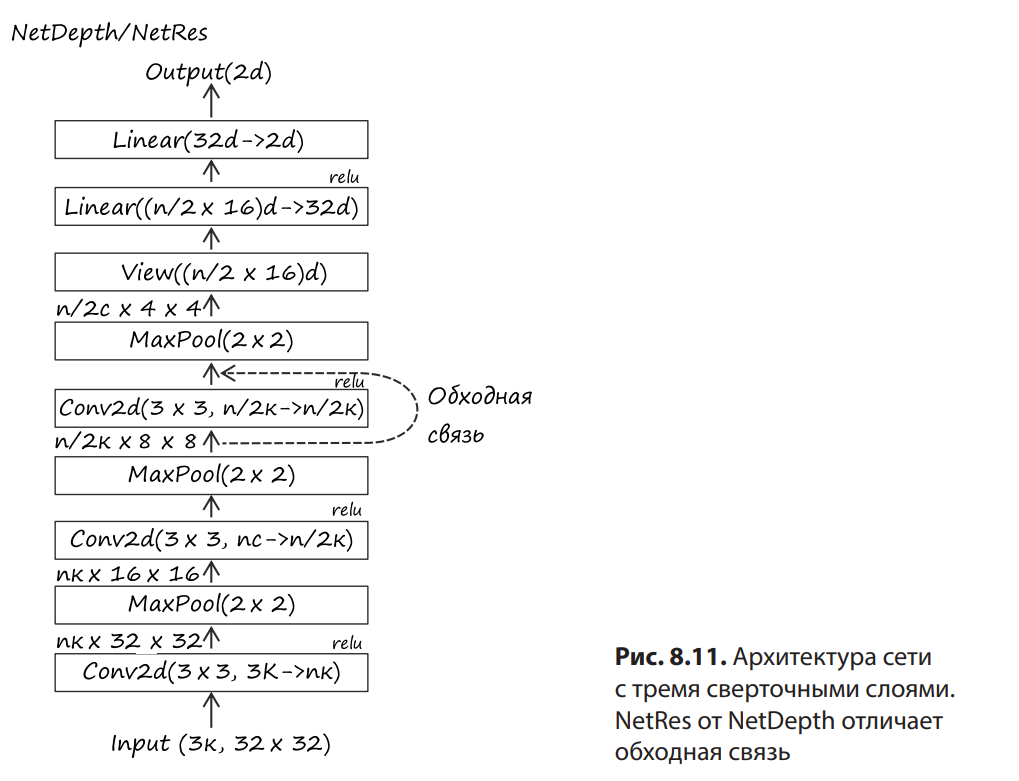

Обходные связи означают просто добавление входного сигнала какого-либо слоя
к выходному сигналу одного из блоков слоев. Именно так они и реализуются
в PyTorch. Добавим в нашу простую сверточную модель еще один слой и для разнообразия воспользуемся функцией активации ReLU. Наш несложный модуль
с дополнительным слоем выглядит следующим образом:

In [55]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

Добавление в эту модель обходной связи наподобие ResNet сводится к прибавлению выходного сигнала первого слоя в функции forward к входному сигналу
третьего слоя:

In [56]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1 
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, n_chans1 //2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten(1)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = self.flatten(out)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
model = NetRes().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:28:22.699973 Epoch 1, Training loss 0.6135842037049068
2023-09-16 11:28:29.354948 Epoch 10, Training loss 0.3313846071814276
2023-09-16 11:28:36.595973 Epoch 20, Training loss 0.29034750182537516
2023-09-16 11:28:43.836972 Epoch 30, Training loss 0.25385009559096805
2023-09-16 11:28:51.097947 Epoch 40, Training loss 0.22163629992182848
2023-09-16 11:28:58.412947 Epoch 50, Training loss 0.19192988684128046
2023-09-16 11:29:05.704974 Epoch 60, Training loss 0.16476564230338023
2023-09-16 11:29:12.951637 Epoch 70, Training loss 0.14242077417149665
2023-09-16 11:29:20.165635 Epoch 80, Training loss 0.11731489873520888
2023-09-16 11:29:27.369635 Epoch 90, Training loss 0.09802236833912172
2023-09-16 11:29:34.598638 Epoch 100, Training loss 0.07644283862867553


In [58]:
model.eval()

all_acc_dict["ResNet"] = validate(model, train_loader, val_loader)

Accuracy train: 0.88
Accuracy val: 0.86


Другими словами, мы воспользовались выходным сигналом первых функций
активации в качестве входных сигналов для последних, помимо стандартного
пути прямого распространения. Другое название этого процесса — тождественное отображение (identity mapping). Как же оно помогает решить проблему
исчезающих градиентов, упомянутую нами ранее?

Если говорить об обратном распространении ошибки, удобно, что обходная связь
(или последовательность обходных связей в глубокой сети) создает прямой путь
от расположенных глубоко параметров к функции потерь, благодаря чему они
вносят более непосредственный вклад в градиент функции потерь, ведь частные
производные функции потерь по этим параметрам теперь получают шанс не
умножаться на коэффициенты в длинной цепочке прочих операций.

Отмечается, что обходные связи благотворно влияют на сходимость, особенно
на начальных этапах обучения. Кроме того, поверхность функции потерь глубоких остаточных сетей намного глаже, чем у сетей прямого распространения
той же глубины и ширины.


Стоит отметить, что обходные связи не были чем-то новым на момент появления ResNet. Обходные связи уже использовались, в том или ином виде, в магистральных сетях (highway networks) и U-Net. Впрочем, способ применения
обходных связей в ResNet дал возможность успешно обучать модели глубиной
более 100 слоев

С момента появления ResNet обходные связи вышли в других архитектурах сетей
на новый уровень. В частности, в одной из них, DenseNet, предлагается связывать
каждый слой с несколькими другими, расположенными далее в сети слоями посредством обходных связей, достигая результатов на самом передовом уровне при
меньшем количестве параметров. И мы уже знаем, как можно реализовать что-то
наподобие DenseNet: просто арифметически прибавить предыдущие промежуточные выходные сигналы к последующим промежуточным входным сигнала

### Создание очень глубоких моделей в PyTorch

Мы говорили о сверточных нейронных сетях более чем из 100 слоев. Как создать
подобную сеть в PyTorch и не сойти с ума в процессе? Обычная стратегия: описать стандартный блок, например (Conv2d, ReLU, Conv2d) + блок обходной связи,
а затем динамически создавать сеть в цикле for. Взглянем, как это происходит
на практике. Мы создадим сеть, приведенную на рис. 8.12

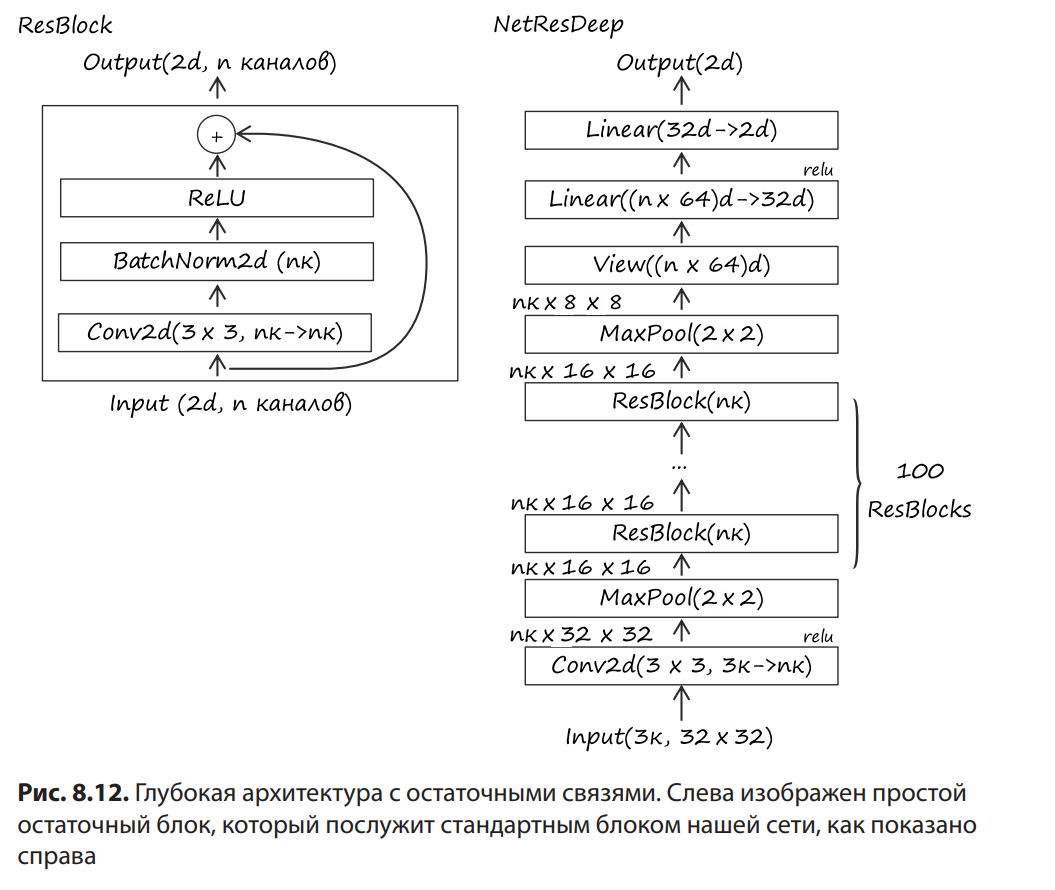

Сначала мы создадим подкласс модуля, единственная задача которого будет состоять в организации вычислений одного блока: одной группы операций свертки,
функции активации и обходной связи:

In [59]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias = False)
        # Слой BatchNorm свел бы на нет эффект смещения, так что его обычно опускают
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        """ 
        Использует пользовательские функции активации. 
        Начальные значения kaiming_normal_ — случайные элементы 
        из нормального распределения со стандартным отклонением, 
        вычисленным в соответствии со статьей о ResNet. 
        Начальные значения нормализации по батчам задаются 
        таким образом, чтобы получить выходные распределения 
        с начальным средним значением 0 и дисперсией 0,5
         """
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

Поскольку мы хотим сгенерировать глубокую модель, то включаем в блок нормализацию по батчам, которая поможет предотвратить «исчезновение» градиентов
во время обучения. Теперь мы хотели бы сгенерировать сеть из 100 блоков. Значит ли это, что нам нужно готовиться к утомительному копированию/вставке?
Вовсе нет: у нас уже есть все необходимое, чтобы понять, как она будет выглядеть.

Прежде всего, в init мы создаем nn.Sequential со списком экземпляров ResBlock. nn.Sequential гарантирует, что выходной сигнал одного блока будет
использован как входной сигнал следующего, а также что все параметры
блока видимы Net. Далее мы просто вызываем в функции forward экземпляр
nn.Sequential для обхода всех 100 блоков и получения результата:

In [60]:
print (*(35 * ['4']))

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4


In [61]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten(1)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = self.flatten(out)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [62]:
model = NetResDeep().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:29:37.049718 Epoch 1, Training loss 0.4743904879518375
2023-09-16 11:29:54.662107 Epoch 10, Training loss 0.2578078954937352
2023-09-16 11:30:14.223350 Epoch 20, Training loss 0.17762947974690965
2023-09-16 11:30:33.723512 Epoch 30, Training loss 0.11349690026918034
2023-09-16 11:30:53.046848 Epoch 40, Training loss 0.05355080823372504
2023-09-16 11:31:13.058935 Epoch 50, Training loss 0.05984355081584613
2023-09-16 11:31:33.190714 Epoch 60, Training loss 0.013969652467425082
2023-09-16 11:31:53.524129 Epoch 70, Training loss 0.008336209840360721
2023-09-16 11:32:14.200578 Epoch 80, Training loss 0.03576228431586152
2023-09-16 11:32:34.915828 Epoch 90, Training loss 0.010053028431157492
2023-09-16 11:32:55.162416 Epoch 100, Training loss 0.005479529726164783


In [63]:
model.eval()

all_acc_dict["NetResDeep"] = validate(model, train_loader, val_loader)

Accuracy train: 0.78
Accuracy val: 0.76


В реализации мы параметризуем количество слоев ради удобства переиспользования и проведения различных опытов. Конечно же, обратное распространение
ошибки будет работать так, как и ожидалось. Неудивительно, что сходимость
этой сети происходит намного медленнее, и сходимость эта более хрупкая. 
Именно поэтому мы тщательнее подобрали начальные значения и обучали
нашу NetRes со скоростью обучения 3e–3 вместо 1e–2, как при обучении других
наших сетей. Мы не обучали ни одну из них до стадии сходимости, но без этих
уловок ничего бы не получилось

Это не значит, что вам следует стремиться углублять сети для набора данных
изображений 32 × 32, но четко показывает, как сделать это для более сложных
наборов данных наподобие ImageNet. А также предоставляет все необходимое
для понимания уже существующих реализаций моделей наподобие ResNet, например, в torchvision

### Инициализация

Небольшой комментарий относительно вышеупомянутого задания начальных
значений. Задание начальных значений — это один из важнейших приемов обучения нейронных сетей. К сожалению, по историческим причинам начальные
значения по умолчанию для весовых коэффициентов в PyTorch неидеальны. 
Производятся активные попытки решить эту проблему; за их ходом можно
следить на GitHub (https://github.com/pytorch/pytorch/issues/18182). Тем временем
нам придется исправлять начальные значения весов самостоятельно. Мы обнаружили, что наша модель не сходится, и изучили распространенные варианты
начальных значений (меньшая дисперсия весов, а также нулевое среднее значение и единичная дисперсия на выходе для нормализации по батчам), а затем
уменьшили дисперсию выходного сигнала вдвое при нормализации по батчам,
когда сеть не сходилась

Инициализации весов можно посвятить целую главу, но нам это представляется излишним. В главе 11 мы снова столкнемся с вопросом задания начальных значений и воспользуемся вариантом, который вполне мог бы служить в PyTorch значением по умолчанию без особых пояснений. Когда вы дорастете
до того, что нюансы задания начальных значений весов начнут вас всерьез
интересовать, — вероятно, не раньше чем дочитаете эту книгу, — можете вернуться к этому вопросу

In [64]:
model = Net().to(device=device)
model.train()
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-09-16 11:32:56.638880 Epoch 1, Training loss 0.6502884960478279
2023-09-16 11:33:02.335856 Epoch 10, Training loss 0.45440130818421676
2023-09-16 11:33:08.842854 Epoch 20, Training loss 0.3917529556401976
2023-09-16 11:33:15.285900 Epoch 30, Training loss 0.3352679321720342
2023-09-16 11:33:21.805951 Epoch 40, Training loss 0.31556976401502157
2023-09-16 11:33:28.365986 Epoch 50, Training loss 0.3025375825774138
2023-09-16 11:33:34.872987 Epoch 60, Training loss 0.2930452578766331
2023-09-16 11:33:41.371987 Epoch 70, Training loss 0.2837518870735624
2023-09-16 11:33:47.901035 Epoch 80, Training loss 0.2753814429424371
2023-09-16 11:33:54.405035 Epoch 90, Training loss 0.2684228479102918
2023-09-16 11:34:01.031035 Epoch 100, Training loss 0.25836406856965105


In [65]:
model.eval()

all_acc_dict["Base"] = validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.88


***
# Итоги

Подытожим эффект от каждой из наших модификаций архитектуры по отдельности на графике Не стоит придавать слишком большое значение каким-либо

конкретным числам — мы достаточно сильно упростили наши задачи и эксперименты, так что повторение конкретного эксперимента с различными случайными начальными значениями приведет, вероятно, к значительным различиям
в точности проверки. Для этой демонстрации мы взяли все прочие элементы
равными, от скорости обучения до количества эпох обучения; на практике мы
пытались бы добиться наилучших результатов путем их изменения. Кроме
того, вероятно, мы бы захотели присоединить некоторые из дополнительных
архитектурных элементов.

Не помешают также количественные наблюдения: как мы видели в подразделе 5.5.3 при обсуждении проверки и переобучения, у регуляризаций в виде
затухания весов и дропаута, у которых статистическая интерпретация в качестве
методов регуляризации более строгая, чем нормализация по батчам, расхождение между интересующими нас двумя показателями безошибочности намного
меньше. Нормализация по батчам, предназначенная скорее для улучшения
сходимости, позволяет обучать сеть до степени безошибочности практически
100 %, так что мы будем интерпретировать два первых метода как методы регуляризации.

In [66]:
import numpy as np

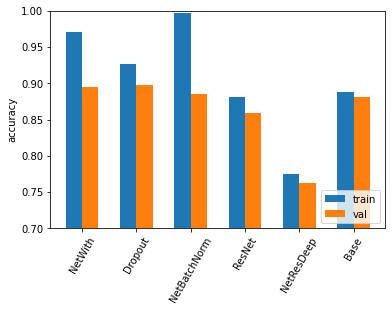

In [67]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()